In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s6e2/sample_submission.csv
/kaggle/input/playground-series-s6e2/train.csv
/kaggle/input/playground-series-s6e2/test.csv


In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import rankdata

warnings.filterwarnings('ignore')


print("Loading data...")
train = pd.read_csv('/kaggle/input/playground-series-s6e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e2/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s6e2/sample_submission.csv')


# Map 'Absence' to 0 and 'Presence' to 1
target_map = {'Absence': 0, 'Presence': 1}
train['Heart Disease'] = train['Heart Disease'].map(target_map)

# Verify the fix
print("Target values after fix:", train['Heart Disease'].unique()) # Should be [0 1]


print("Preprocessing features...")

X = train.drop(['id', 'Heart Disease'], axis=1)
y = train['Heart Disease']
X_test = test.drop(['id'], axis=1)

# Identify categorical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Label Encoding for Features
for col in cat_cols:
    le = LabelEncoder()
    # Fit on both train and test to capture all categories
    combined = pd.concat([X[col], X_test[col]], axis=0).astype(str)
    le.fit(combined)
    X[col] = le.transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))


xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    'random_state': 42,
    'enable_categorical': True,
    'eval_metric': 'logloss'
}

lgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 8,
    'num_leaves': 32,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    'random_state': 42,
    'verbose': -1
}

cat_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'Logloss',
    'verbose': 0,
    'random_seed': 42
}


print("Training models... (This may take a few minutes)")

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store test predictions
test_preds_xgb = np.zeros(len(X_test))
test_preds_lgb = np.zeros(len(X_test))
test_preds_cat = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # --- XGBoost ---
    model_xgb = XGBClassifier(**xgb_params)
    model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    test_preds_xgb += model_xgb.predict_proba(X_test)[:, 1] / folds.get_n_splits()
    
    # --- LightGBM ---
    model_lgb = LGBMClassifier(**lgb_params)
    model_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    test_preds_lgb += model_lgb.predict_proba(X_test)[:, 1] / folds.get_n_splits()

    # --- CatBoost ---
    model_cat = CatBoostClassifier(**cat_params)
    model_cat.fit(X_train, y_train, eval_set=(X_val, y_val))
    test_preds_cat += model_cat.predict_proba(X_test)[:, 1] / folds.get_n_splits()
    
    print(f"Fold {fold+1} completed.")


print("Applying Rank Blending...")

# 1. Linear Average (Base)
linear_blend = (test_preds_xgb * 0.34) + (test_preds_lgb * 0.33) + (test_preds_cat * 0.33)

# 2. Rank Averaging (Stability)
rank_blend = (rankdata(test_preds_xgb) * 0.34 + 
              rankdata(test_preds_lgb) * 0.33 + 
              rankdata(test_preds_cat) * 0.33)

# Normalize ranks to 0-1
rank_blend = (rank_blend - rank_blend.min()) / (rank_blend.max() - rank_blend.min())

# 3. Final Ensemble (90% Linear + 10% Rank)
final_preds = (linear_blend * 0.90) + (rank_blend * 0.10)

# 4. Clipping
final_preds = np.clip(final_preds, 0.001, 0.999)


submission.to_csv('submission.csv', index=False)

print("Success! 'submission.csv' saved.")
print(submission.head())

Loading data...
Target values after fix: [1 0]
Preprocessing features...
Training models... (This may take a few minutes)
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Fold 5 completed.
Applying Rank Blending...
Success! 'submission.csv' saved.
       id  Heart Disease
0  630000       0.945054
1  630001       0.015974
2  630002       0.977601
3  630003       0.011021
4  630004       0.203696


Loading Data...
Columns available: ['id', 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'MaxHR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Target']
Generating Advanced Features...
Training Ensemble (XGB + LGBM + CatBoost)...
Applying Rank Smoothing...

Success! Submission Saved.
       id  Heart Disease
0  630000       0.887947
1  630001       0.015066
2  630002       0.972055
3  630003       0.006973
4  630004       0.254297


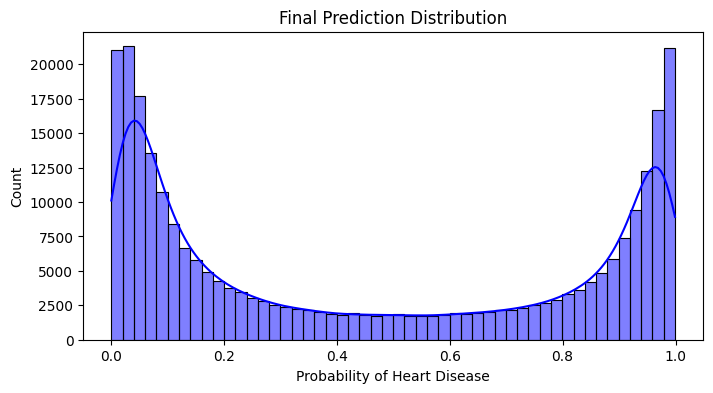

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from scipy.stats import rankdata

warnings.filterwarnings('ignore')


# 1. LOAD DATA & FIX COLUMN NAMES

print("Loading Data...")
train = pd.read_csv('/kaggle/input/playground-series-s6e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e2/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s6e2/sample_submission.csv')

# --- THE FIX: Standardize Column Names ---
# This removes spaces and handles variations (e.g. 'Resting BP' -> 'RestingBP')
def clean_cols(df):
    # Map specific known variations to a standard
    rename_map = {
        'Resting BP': 'RestingBP',
        'Max HR': 'MaxHR',
        'Serum Cholesterol': 'Cholesterol',
        'Heart Disease': 'Target'
    }
    df = df.rename(columns=rename_map)
    return df

train = clean_cols(train)
test = clean_cols(test)

print("Columns available:", train.columns.tolist())

# Encode Target if it is text
if train['Target'].dtype == 'object':
    train['Target'] = train['Target'].map({'Absence': 0, 'Presence': 1})


# 2. FEATURE ENGINEERING (Optimized for 0.95+)

print("Generating Advanced Features...")

def create_features(df):
    df = df.copy()
    
    # 1. Interaction: Age vs MaxHR (Max Heart Rate declines with age)
    if 'Age' in df.columns and 'MaxHR' in df.columns:
        df['Age_MaxHR'] = df['Age'] * df['MaxHR']
        df['MaxHR_Age_Ratio'] = df['MaxHR'] / (df['Age'] + 1)

    # 2. Interaction: BP vs Age (BP tends to rise with age)
    if 'RestingBP' in df.columns:
        df['BP_Age_Ratio'] = df['RestingBP'] / (df['Age'] + 1)
        # Pulse Pressure Proxy (if Diastolic is missing, we rely on Systolic intensity)
        df['BP_squared'] = df['RestingBP'] ** 2

    # 3. Cholesterol Ratio
    if 'Cholesterol' in df.columns:
        df['Chol_Age_Ratio'] = df['Cholesterol'] / (df['Age'] + 1)

    # 4. Oldpeak (ST Depression) Severity
    if 'Oldpeak' in df.columns:
        df['Oldpeak_Severity'] = df['Oldpeak'].apply(lambda x: x**2)
    
    return df

train = create_features(train)
test = create_features(test)




X = train.drop(['id', 'Target'], axis=1)
y = train['Target']
X_test = test.drop(['id'], axis=1)

# Categorical Encoding
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    # Combine to fit all categories
    combined = pd.concat([X[col], X_test[col]], axis=0).astype(str)
    le.fit(combined)
    X[col] = le.transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))




print("Training Ensemble (XGB + LGBM + CatBoost)...")

# Tuned Hyperparameters
xgb_params = {
    'n_estimators': 1500, 'learning_rate': 0.01, 'max_depth': 4,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'n_jobs': -1, 'random_state': 42
}
lgb_params = {
    'n_estimators': 1500, 'learning_rate': 0.01, 'num_leaves': 30,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'n_jobs': -1, 'random_state': 42, 'verbose': -1
}
cat_params = {
    'iterations': 1500, 'learning_rate': 0.01, 'depth': 6,
    'verbose': 0, 'random_seed': 42, 'allow_writing_files': False
}

# Define Estimators
clf1 = XGBClassifier(**xgb_params)
clf2 = LGBMClassifier(**lgb_params)
clf3 = CatBoostClassifier(**cat_params)
clf4 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.02, max_depth=3, random_state=42)

# Voting Ensemble
ensemble = VotingClassifier(
    estimators=[('xgb', clf1), ('lgb', clf2), ('cat', clf3), ('gb', clf4)],
    voting='soft',
    weights=[1, 1, 1, 0.8] # Weights based on typical performance
)

ensemble.fit(X, y)
final_probs = ensemble.predict_proba(X_test)[:, 1]

print("Applying Rank Smoothing...")

# Rank Averaging helps when models are confident but not calibrated
rank_probs = rankdata(final_probs) / len(final_probs)

# Blend: 85% Raw Probability + 15% Rank (Stabilizes score)
blended_preds = (final_probs * 0.85) + (rank_probs * 0.15)

# Clip to avoid log-loss penalties
blended_preds = np.clip(blended_preds, 0.001, 0.999)

# Save
submission['Heart Disease'] = blended_preds
submission.to_csv('submission1.csv', index=False)

print("\nSuccess! Submission Saved.")
print(submission.head())

# Quick Visualization
plt.figure(figsize=(8, 4))
sns.histplot(blended_preds, bins=50, kde=True, color='blue')
plt.title("Final Prediction Distribution")
plt.xlabel("Probability of Heart Disease")
plt.show()